Firt name: Huaiyu  
Last name: Guo  
USC ID: 6391491605  
Github Username: Koheyo

### import

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from tensorflow.keras.regularizers import l2

### Data Exploration and Pre-processing

In [2]:
#reference: https://docs.python.org/3.13/library/glob.html

train_images = []
test_images = []
class_names = os.listdir('../data/RealWaste')

for class_name in class_names:
    folder = os.path.join('../data/RealWaste', class_name)
    images = sorted(glob.glob(folder + '/*.jpg'))
    n_train = int(len(images) * 0.8)
    for img in images[:n_train]:
        train_images.append((img, class_name))
    for img in images[n_train:]:
        test_images.append((img, class_name))

In [3]:
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(class_names)

onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [4]:
X_train = []
y_train = []

def load_and_resize(img_path, size=(224, 224)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img


for img_path, class_name in train_images:
    img = load_and_resize(img_path)
    X_train.append(img)
    y_train.append(class_name)

In [5]:
# Process test set images
X_test = []
y_test = []

for img_path, class_name in test_images:
    img = load_and_resize(img_path)
    X_test.append(img)
    y_test.append(class_name)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

# Encode labels
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# One-hot encode labels
y_train = onehot_encoder.transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

### Transfer Learning

In [6]:
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
#reference: https://keras.io/api/preprocessing/image/#imagedatagenerator-class

# Enhance data augmentation with more transformations to improve model generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2,
    fill_mode='nearest'
)

In [7]:
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2
#reference: https://keras.io/api/models/model/
#reference: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
#reference: https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class
#reference: https://keras.io/guides/transfer_learning/


def build_model_with_head(base_model, num_classes):
    #Build a model with custom head for transfer learning

    x = base_model.output
    # Add Global Average Pooling to reduce parameters
    x = GlobalAveragePooling2D()(x)
    
    # First Dense layer with L2 regularization
    x = Dense(256, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    # Second Dense layer
    x = Dense(128, kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    
    # Output layer
    predictions = Dense(num_classes, 
                      activation='softmax',
                      kernel_regularizer=l2(0.01))(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile model with multiple metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()]
    )
    
    return model

In [8]:

train_imgs, val_imgs = train_test_split(
    train_images,
    test_size=0.2,
    stratify=[label for _, label in train_images],  # Ensure that each category is allocated proportionally
    random_state=42
)

In [9]:
X_val = []
y_val = []
for img_path, class_name in val_imgs:
    img = load_and_resize(img_path)
    X_val.append(img)
    y_val.append(class_name)

X_val = np.array(X_val)
y_val = label_encoder.transform(y_val)
y_val = onehot_encoder.transform(y_val.reshape(-1, 1))

In [10]:
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

def evaluate_model(model, X, y, class_names, dataset_name="Dataset"):

    #Comprehensive model evaluation with multiple metrics

    # Get predictions
    y_pred = model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y, axis=1)
    
    # Calculate metrics
    print(f"\n{dataset_name} Evaluation:")
    print("-" * 50)
    
    # Classification report (includes precision, recall, f1-score)
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
    
    # Calculate AUC
    auc = roc_auc_score(y, y_pred, multi_class='ovr')
    print(f"AUC Score: {auc:.4f}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'auc': auc,
        'precision': precision_score(y_true_classes, y_pred_classes, average='weighted'),
        'recall': recall_score(y_true_classes, y_pred_classes, average='weighted'),
        'f1': f1_score(y_true_classes, y_pred_classes, average='weighted')
    }

In [11]:
#https://keras.io/api/callbacks/learning_rate_scheduler/

def plot_training_history(history, model_name):

    #Plot comprehensive training history

    # Create subplots with 1x3 layout
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot training & validation accuracy
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Validation'])
    
    # Plot training & validation loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Validation'])
    
    # Plot learning rate if available
    if 'lr' in history.history:
        axes[2].plot(history.history['lr'])
        axes[2].set_title(f'{model_name} - Learning Rate')
        axes[2].set_ylabel('Learning Rate')
        axes[2].set_xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()
    
    # Save training history
    hist_df = pd.DataFrame(history.history)

In [12]:
#reference: https://keras.io/api/callbacks/early_stopping/
#reference: https://keras.io/api/callbacks/learning_rate_scheduler/

# Define common callbacks for all models
def get_callbacks(model_name):
    
    #Get callbacks for model training

    return [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        # Reduce learning rate when training plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )
    ]

### ResNet50

Training ResNet50...
Epoch 1/100
759/759 [==============================] - 38s 46ms/step - loss: 5.1092 - accuracy: 0.5146 - precision_1: 0.6734 - recall_1: 0.3267 - auc_1: 0.8744 - val_loss: 2.9267 - val_accuracy: 0.7171 - val_precision_1: 0.8122 - val_recall_1: 0.6145 - val_auc_1: 0.9585 - lr: 0.0010
Epoch 2/100
759/759 [==============================] - 35s 46ms/step - loss: 2.8007 - accuracy: 0.5948 - precision_1: 0.7222 - recall_1: 0.4413 - auc_1: 0.9160 - val_loss: 2.2503 - val_accuracy: 0.6842 - val_precision_1: 0.7469 - val_recall_1: 0.6289 - val_auc_1: 0.9524 - lr: 0.0010
Epoch 3/100
759/759 [==============================] - 35s 46ms/step - loss: 2.4407 - accuracy: 0.5779 - precision_1: 0.7168 - recall_1: 0.4332 - auc_1: 0.9118 - val_loss: 1.8704 - val_accuracy: 0.7513 - val_precision_1: 0.8490 - val_recall_1: 0.6658 - val_auc_1: 0.9711 - lr: 0.0010
Epoch 4/100
759/759 [==============================] - 35s 45ms/step - loss: 2.2968 - accuracy: 0.6074 - precision_1: 0.7348 - 

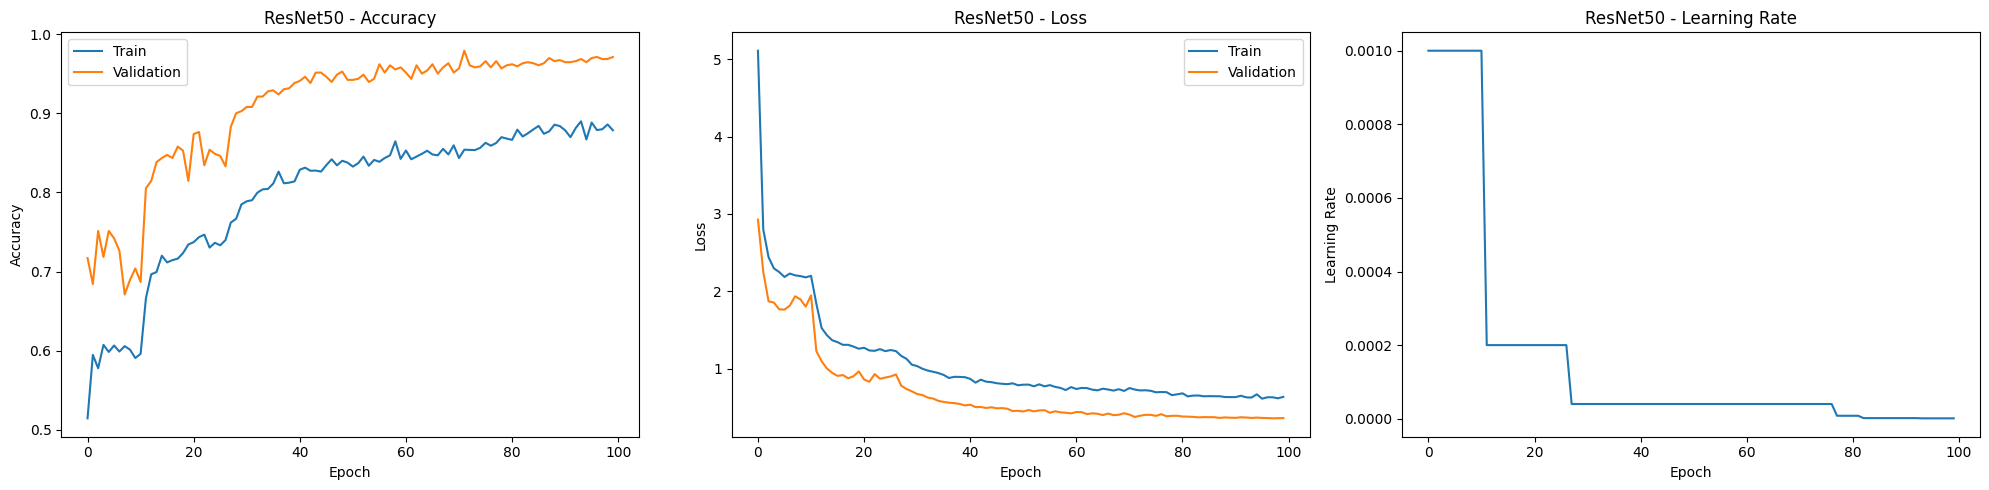

119/119 [==============================] - 4s 33ms/step

Train Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.96      0.99      0.98       368
      2-Food Organics       0.99      0.97      0.98       328
              3-Glass       0.92      0.99      0.95       336
              4-Metal       0.95      0.99      0.97       632
5-Miscellaneous Trash       0.99      0.87      0.92       396
              6-Paper       0.98      0.99      0.99       400
            7-Plastic       0.99      0.93      0.96       736
      8-Textile Trash       0.99      0.98      0.99       254
         9-Vegetation       0.90      1.00      0.95       348

             accuracy                           0.96      3798
            macro avg       0.96      0.97      0.96      3798
         weighted avg       0.97      0.96      0.96      3798

AUC Score: 0.9995


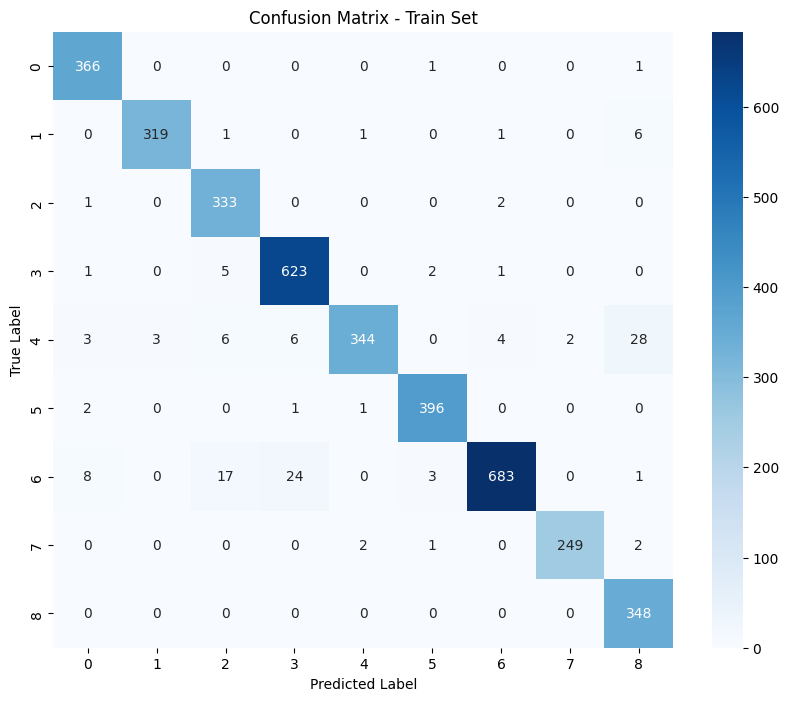

24/24 [==============================] - 1s 29ms/step

Validation Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       1.00      1.00      1.00        74
      2-Food Organics       1.00      0.97      0.98        66
              3-Glass       0.94      1.00      0.97        67
              4-Metal       0.95      1.00      0.98       126
5-Miscellaneous Trash       0.99      0.85      0.91        79
              6-Paper       1.00      0.99      0.99        80
            7-Plastic       0.99      0.95      0.97       147
      8-Textile Trash       0.98      1.00      0.99        51
         9-Vegetation       0.89      1.00      0.94        70

             accuracy                           0.97       760
            macro avg       0.97      0.97      0.97       760
         weighted avg       0.97      0.97      0.97       760

AUC Score: 0.9998


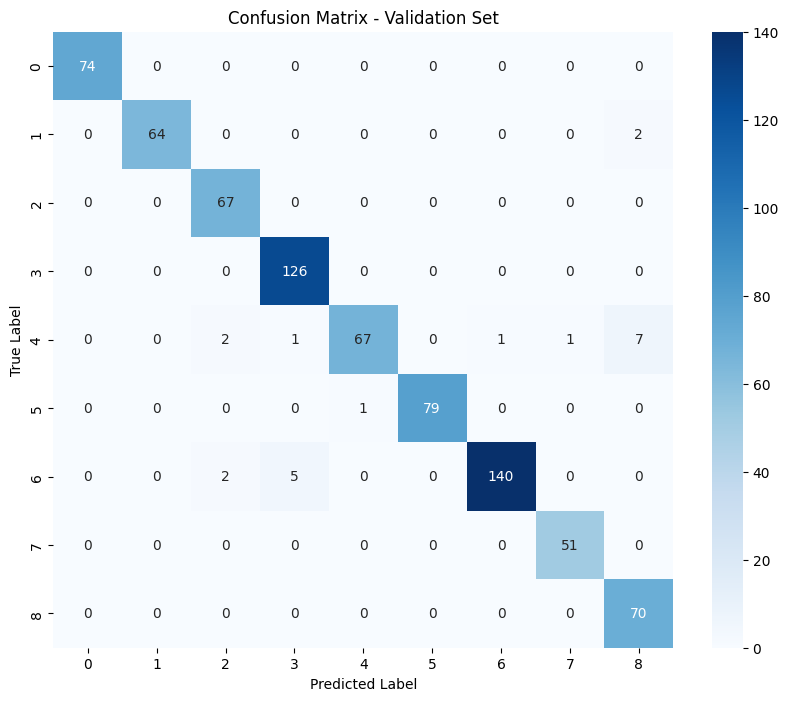

30/30 [==============================] - 1s 37ms/step

Test Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.75      0.92      0.83        93
      2-Food Organics       0.83      0.76      0.79        83
              3-Glass       0.70      0.79      0.74        84
              4-Metal       0.71      0.91      0.79       158
5-Miscellaneous Trash       0.71      0.47      0.57        99
              6-Paper       0.90      0.92      0.91       100
            7-Plastic       0.83      0.70      0.76       185
      8-Textile Trash       0.88      0.59      0.71        64
         9-Vegetation       0.82      0.92      0.87        88

             accuracy                           0.78       954
            macro avg       0.79      0.78      0.77       954
         weighted avg       0.79      0.78      0.78       954

AUC Score: 0.9772


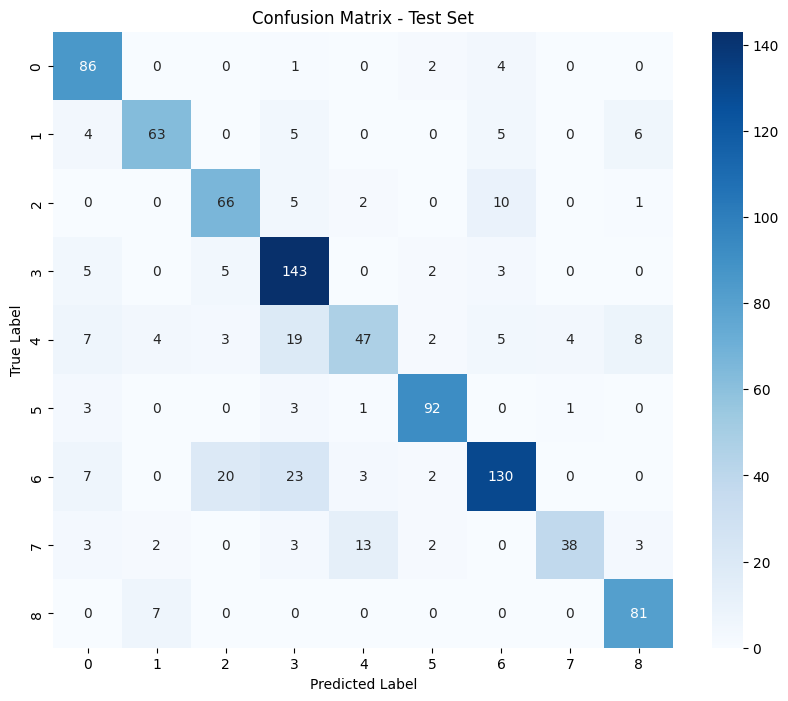

In [13]:
#reference: https://keras.io/api/applications/resnet/#resnet50-function
#reference: https://keras.io/api/models/model/#compile-method
#reference: https://keras.io/api/models/model/#fit-method


from tensorflow.keras.applications import ResNet50

print("Training ResNet50...")
base_model_50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_50.layers:
    layer.trainable = False

model_50 = build_model_with_head(base_model_50, len(class_names))
model_50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Train with callbacks
history_50 = model_50.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    epochs=100,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//5,
    callbacks=get_callbacks('resnet50')
)

# Plot training history
plot_training_history(history_50, 'ResNet50')

# Evaluate model
results_50 = {
    'train': evaluate_model(model_50, X_train, y_train, class_names, "Train Set"),
    'val': evaluate_model(model_50, X_val, y_val, class_names, "Validation Set"),
    'test': evaluate_model(model_50, X_test, y_test, class_names, "Test Set")
}



### ResNet101

Training ResNet101...
Epoch 1/100
759/759 [==============================] - 24s 28ms/step - loss: 5.0768 - accuracy: 0.5131 - precision_3: 0.6565 - recall_3: 0.3224 - auc_3: 0.8763 - val_loss: 2.7909 - val_accuracy: 0.7421 - val_precision_3: 0.8227 - val_recall_3: 0.6776 - val_auc_3: 0.9689 - lr: 0.0010
Epoch 2/100
759/759 [==============================] - 20s 26ms/step - loss: 2.8144 - accuracy: 0.5795 - precision_3: 0.6948 - recall_3: 0.4195 - auc_3: 0.9097 - val_loss: 2.1643 - val_accuracy: 0.7105 - val_precision_3: 0.7754 - val_recall_3: 0.6316 - val_auc_3: 0.9583 - lr: 0.0010
Epoch 3/100
759/759 [==============================] - 20s 26ms/step - loss: 2.3616 - accuracy: 0.6011 - precision_3: 0.7367 - recall_3: 0.4390 - auc_3: 0.9161 - val_loss: 1.9154 - val_accuracy: 0.7132 - val_precision_3: 0.8034 - val_recall_3: 0.6289 - val_auc_3: 0.9624 - lr: 0.0010
Epoch 4/100
759/759 [==============================] - 20s 26ms/step - loss: 2.2767 - accuracy: 0.5950 - precision_3: 0.7220 -

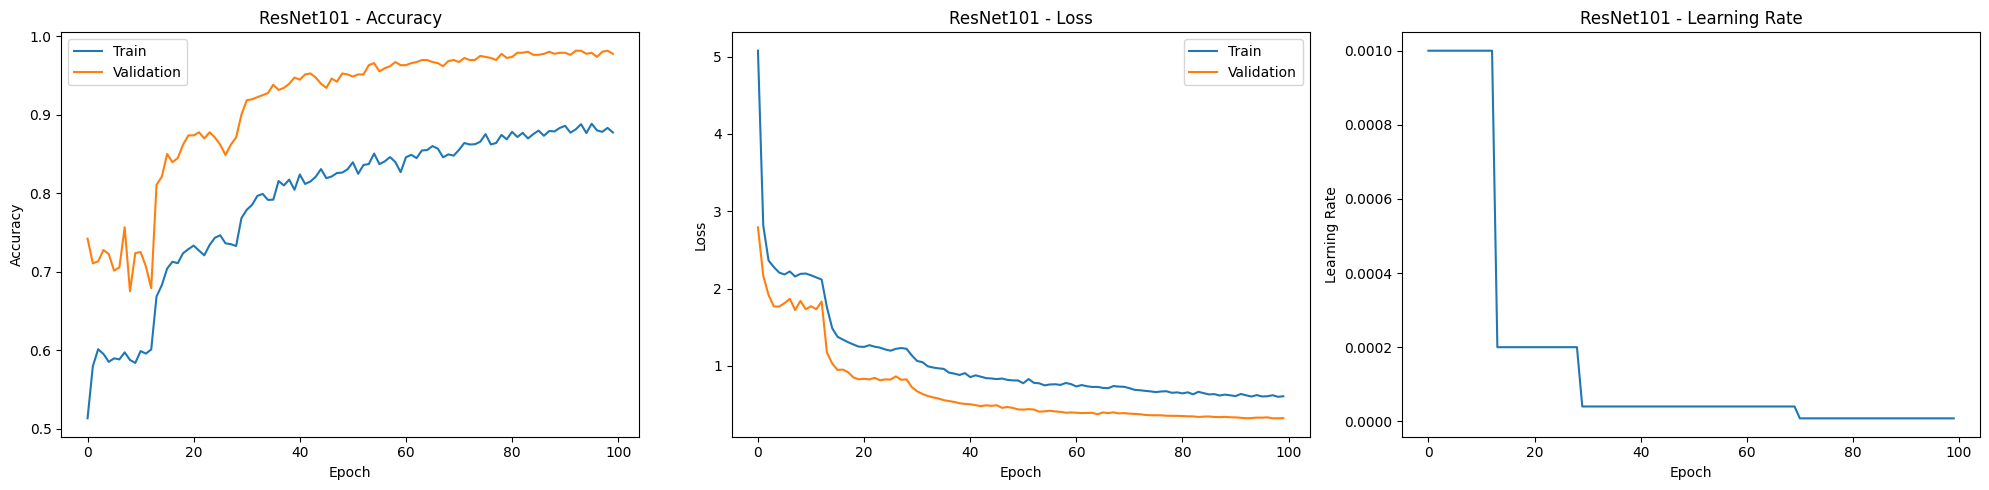

119/119 [==============================] - 6s 43ms/step

Train Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.96      0.99      0.97       368
      2-Food Organics       0.99      0.98      0.99       328
              3-Glass       0.97      1.00      0.98       336
              4-Metal       0.96      1.00      0.98       632
5-Miscellaneous Trash       1.00      0.95      0.97       396
              6-Paper       0.99      0.97      0.98       400
            7-Plastic       0.99      0.95      0.97       736
      8-Textile Trash       0.99      1.00      0.99       254
         9-Vegetation       0.97      1.00      0.98       348

             accuracy                           0.98      3798
            macro avg       0.98      0.98      0.98      3798
         weighted avg       0.98      0.98      0.98      3798

AUC Score: 0.9998


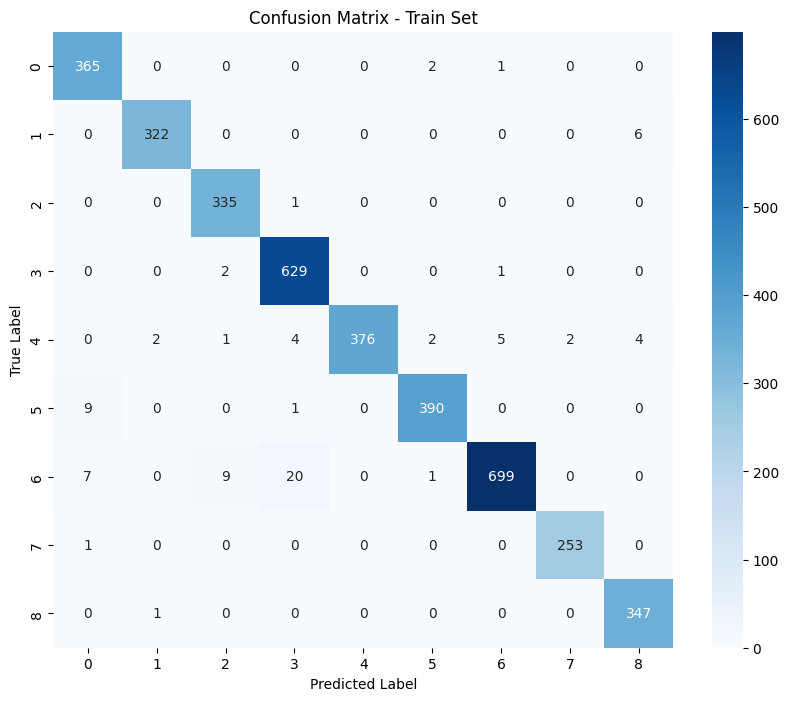

24/24 [==============================] - 1s 41ms/step

Validation Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.95      0.99      0.97        74
      2-Food Organics       1.00      0.97      0.98        66
              3-Glass       0.97      1.00      0.99        67
              4-Metal       0.95      0.99      0.97       126
5-Miscellaneous Trash       1.00      0.96      0.98        79
              6-Paper       0.99      0.96      0.97        80
            7-Plastic       0.99      0.95      0.97       147
      8-Textile Trash       1.00      1.00      1.00        51
         9-Vegetation       0.97      1.00      0.99        70

             accuracy                           0.98       760
            macro avg       0.98      0.98      0.98       760
         weighted avg       0.98      0.98      0.98       760

AUC Score: 0.9997


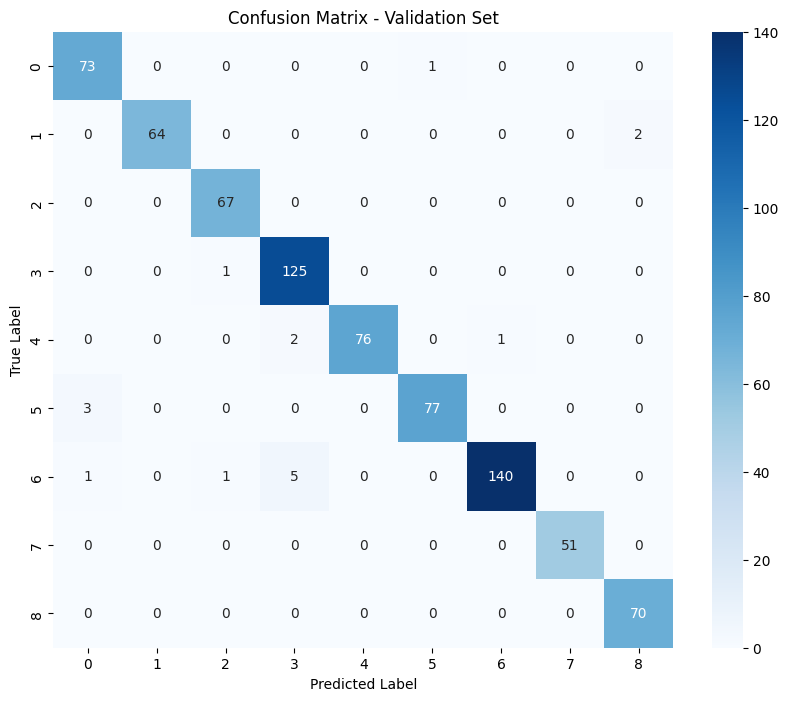

30/30 [==============================] - 1s 42ms/step

Test Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.78      0.86      0.82        93
      2-Food Organics       0.90      0.93      0.91        83
              3-Glass       0.80      0.86      0.83        84
              4-Metal       0.75      0.87      0.81       158
5-Miscellaneous Trash       0.76      0.56      0.64        99
              6-Paper       0.85      0.88      0.86       100
            7-Plastic       0.82      0.75      0.78       185
      8-Textile Trash       0.77      0.67      0.72        64
         9-Vegetation       0.91      0.92      0.92        88

             accuracy                           0.81       954
            macro avg       0.81      0.81      0.81       954
         weighted avg       0.81      0.81      0.81       954

AUC Score: 0.9803


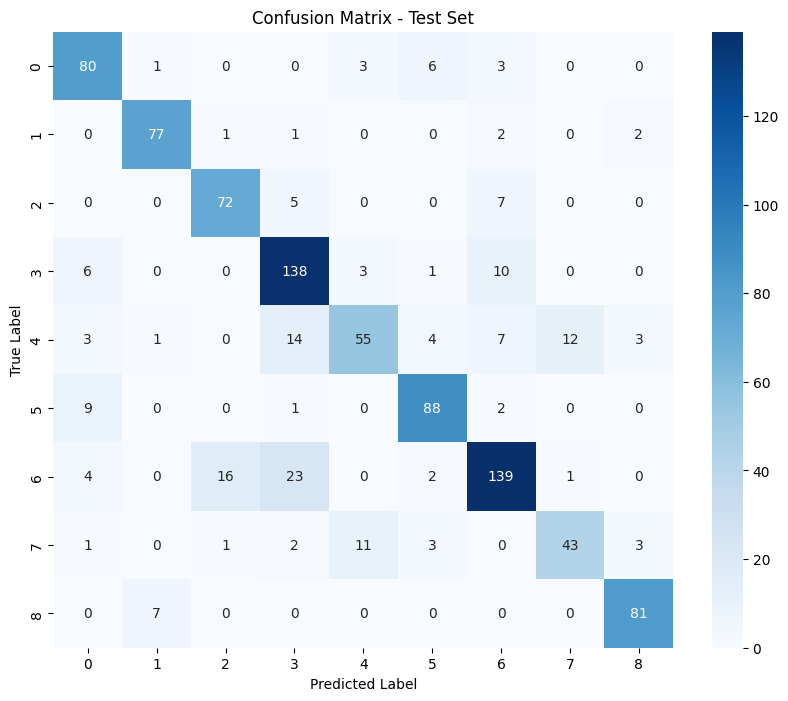

In [14]:
#reference: https://keras.io/api/applications/resnet/#resnet101-function

from tensorflow.keras.applications import ResNet101

print("Training ResNet101...")
base_model_101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_101.layers:
    layer.trainable = False

model_101 = build_model_with_head(base_model_101, len(class_names))
model_101.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Train with callbacks
history_101 = model_101.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    epochs=100,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//5,
    callbacks=get_callbacks('resnet101')
)

# Plot training history
plot_training_history(history_101, 'ResNet101')

# Evaluate model
results_101 = {
    'train': evaluate_model(model_101, X_train, y_train, class_names, "Train Set"),
    'val': evaluate_model(model_101, X_val, y_val, class_names, "Validation Set"),
    'test': evaluate_model(model_101, X_test, y_test, class_names, "Test Set")
}



### EfficientNetB0 

Training EfficientNetB0...
Epoch 1/100
759/759 [==============================] - 21s 24ms/step - loss: 5.1308 - accuracy: 0.5705 - precision_5: 0.7245 - recall_5: 0.3931 - auc_5: 0.8959 - val_loss: 3.0485 - val_accuracy: 0.7224 - val_precision_5: 0.7808 - val_recall_5: 0.6750 - val_auc_5: 0.9632 - lr: 0.0010
Epoch 2/100
759/759 [==============================] - 17s 23ms/step - loss: 2.7642 - accuracy: 0.6288 - precision_5: 0.7461 - recall_5: 0.4896 - auc_5: 0.9263 - val_loss: 2.0036 - val_accuracy: 0.7618 - val_precision_5: 0.8253 - val_recall_5: 0.6961 - val_auc_5: 0.9718 - lr: 0.0010
Epoch 3/100
759/759 [==============================] - 17s 22ms/step - loss: 2.2414 - accuracy: 0.6425 - precision_5: 0.7584 - recall_5: 0.5080 - auc_5: 0.9306 - val_loss: 1.7090 - val_accuracy: 0.7895 - val_precision_5: 0.8549 - val_recall_5: 0.7211 - val_auc_5: 0.9771 - lr: 0.0010
Epoch 4/100
759/759 [==============================] - 17s 22ms/step - loss: 2.0947 - accuracy: 0.6541 - precision_5: 0.7

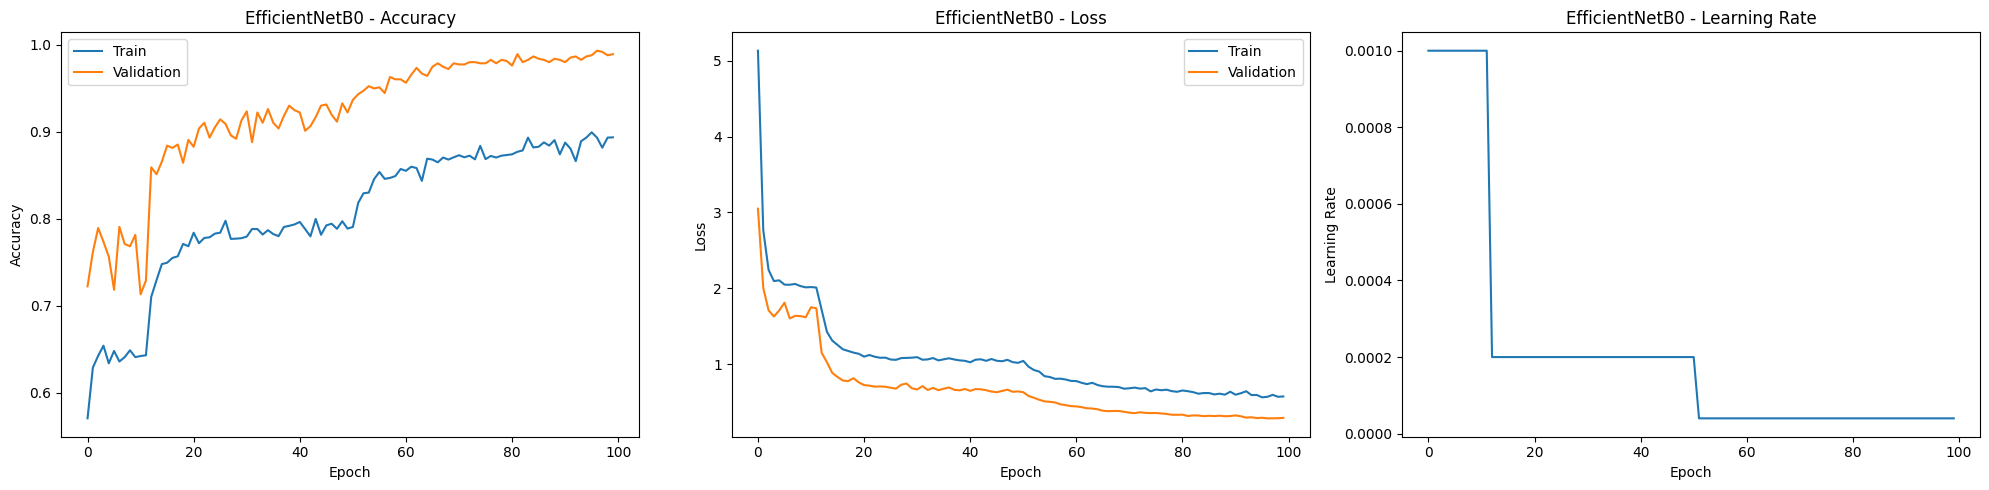

119/119 [==============================] - 3s 21ms/step

Train Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.95      0.99      0.97       368
      2-Food Organics       0.98      0.99      0.99       328
              3-Glass       0.98      0.98      0.98       336
              4-Metal       0.98      0.98      0.98       632
5-Miscellaneous Trash       0.97      0.96      0.97       396
              6-Paper       0.99      0.95      0.97       400
            7-Plastic       0.98      0.98      0.98       736
      8-Textile Trash       0.97      0.99      0.98       254
         9-Vegetation       0.99      0.99      0.99       348

             accuracy                           0.98      3798
            macro avg       0.98      0.98      0.98      3798
         weighted avg       0.98      0.98      0.98      3798

AUC Score: 0.9997


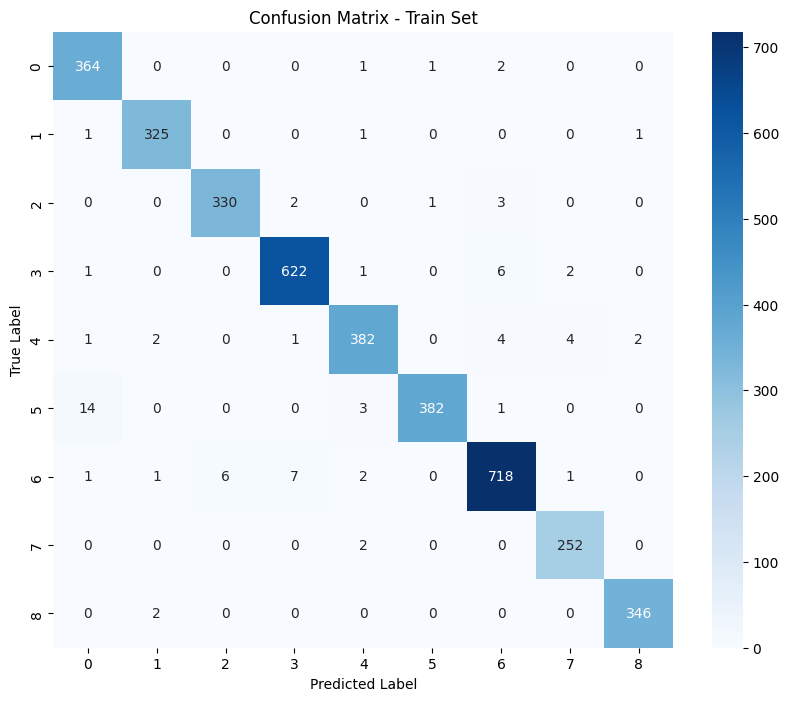

24/24 [==============================] - 0s 19ms/step

Validation Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.95      1.00      0.97        74
      2-Food Organics       1.00      1.00      1.00        66
              3-Glass       0.99      1.00      0.99        67
              4-Metal       1.00      0.99      1.00       126
5-Miscellaneous Trash       0.99      0.97      0.98        79
              6-Paper       1.00      0.95      0.97        80
            7-Plastic       0.99      0.99      0.99       147
      8-Textile Trash       1.00      1.00      1.00        51
         9-Vegetation       0.99      1.00      0.99        70

             accuracy                           0.99       760
            macro avg       0.99      0.99      0.99       760
         weighted avg       0.99      0.99      0.99       760

AUC Score: 0.9999


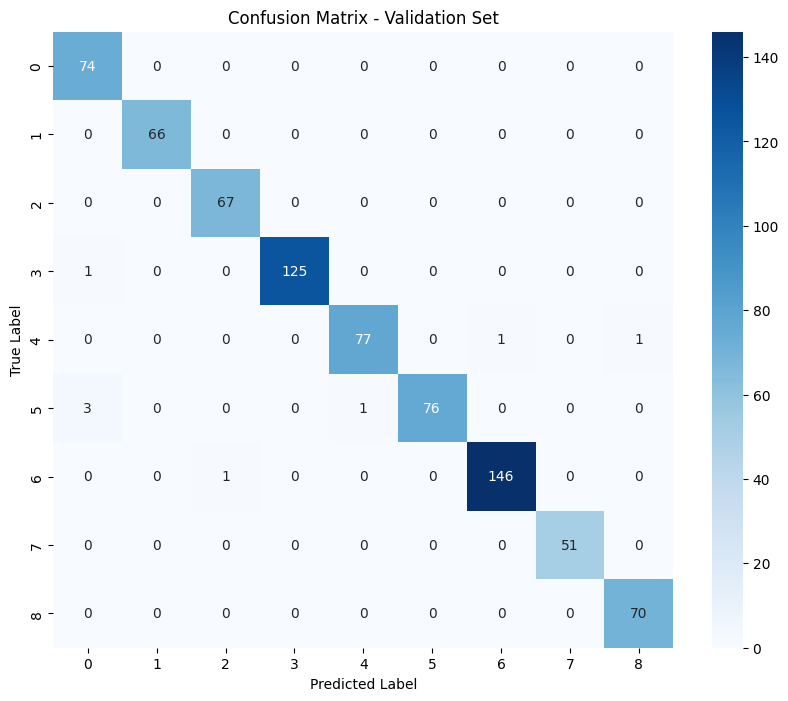

30/30 [==============================] - 1s 26ms/step

Test Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.83      0.88      0.85        93
      2-Food Organics       0.79      0.78      0.79        83
              3-Glass       0.86      0.73      0.79        84
              4-Metal       0.82      0.89      0.85       158
5-Miscellaneous Trash       0.71      0.57      0.63        99
              6-Paper       0.90      0.93      0.92       100
            7-Plastic       0.80      0.85      0.82       185
      8-Textile Trash       0.71      0.78      0.75        64
         9-Vegetation       0.87      0.83      0.85        88

             accuracy                           0.81       954
            macro avg       0.81      0.80      0.81       954
         weighted avg       0.81      0.81      0.81       954

AUC Score: 0.9786


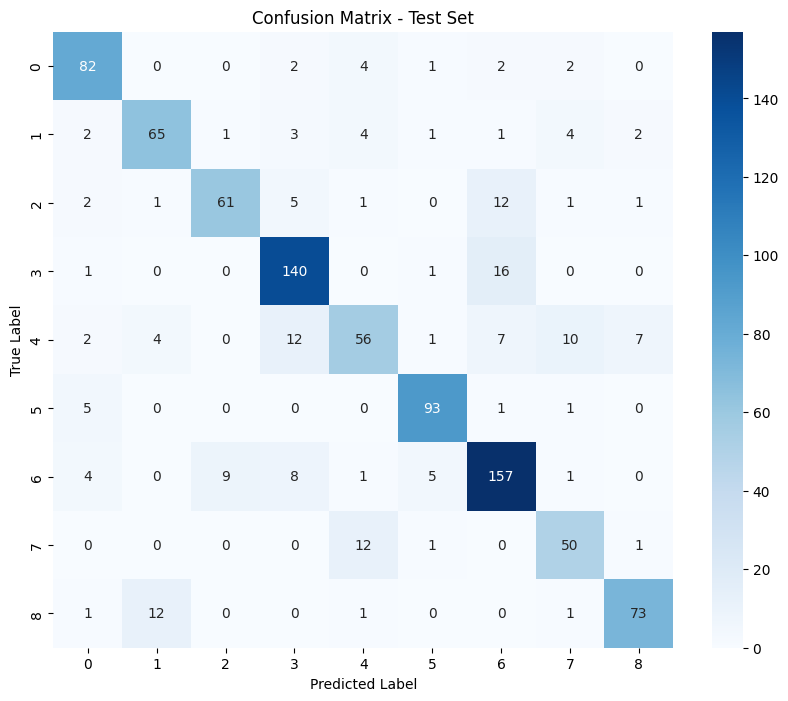

In [16]:
#reference: https://keras.io/api/applications/efficientnet/#efficientnetb0-function
#reference: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
from tensorflow.keras.applications import EfficientNetB0

print("Training EfficientNetB0...")
base_model_eff = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_eff.layers:
    layer.trainable = False

model_eff = build_model_with_head(base_model_eff, len(class_names))
model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Train with callbacks
history_eff = model_eff.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    epochs=100,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//5,
    callbacks=get_callbacks('efficientnet')
)

# Plot training history
plot_training_history(history_eff, 'EfficientNetB0')

# Evaluate model
results_eff = {
    'train': evaluate_model(model_eff, X_train, y_train, class_names, "Train Set"),
    'val': evaluate_model(model_eff, X_val, y_val, class_names, "Validation Set"),
    'test': evaluate_model(model_eff, X_test, y_test, class_names, "Test Set")
}



### VGG16 

Training VGG16...
Epoch 1/100
759/759 [==============================] - 20s 25ms/step - loss: 4.8989 - accuracy: 0.4619 - precision_7: 0.6361 - recall_7: 0.2502 - auc_7: 0.8447 - val_loss: 3.1787 - val_accuracy: 0.6184 - val_precision_7: 0.6984 - val_recall_7: 0.5211 - val_auc_7: 0.9352 - lr: 0.0010
Epoch 2/100
759/759 [==============================] - 17s 23ms/step - loss: 2.8082 - accuracy: 0.5689 - precision_7: 0.7144 - recall_7: 0.3905 - auc_7: 0.9046 - val_loss: 2.1169 - val_accuracy: 0.6632 - val_precision_7: 0.7293 - val_recall_7: 0.5671 - val_auc_7: 0.9476 - lr: 0.0010
Epoch 3/100
759/759 [==============================] - 17s 23ms/step - loss: 2.2532 - accuracy: 0.5755 - precision_7: 0.7150 - recall_7: 0.4028 - auc_7: 0.9042 - val_loss: 1.7602 - val_accuracy: 0.6697 - val_precision_7: 0.7648 - val_recall_7: 0.5776 - val_auc_7: 0.9547 - lr: 0.0010
Epoch 4/100
759/759 [==============================] - 17s 23ms/step - loss: 2.0299 - accuracy: 0.5869 - precision_7: 0.7332 - rec

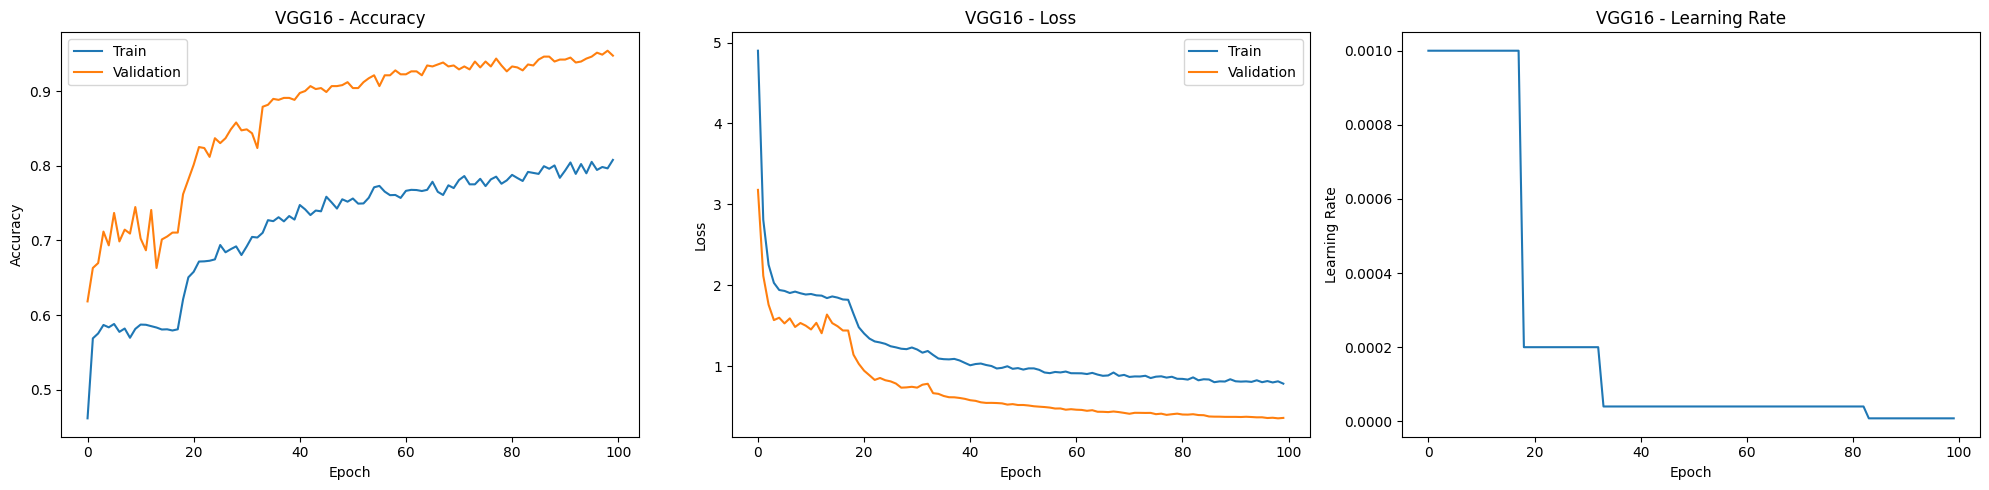

119/119 [==============================] - 6s 51ms/step

Train Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.92      0.97      0.94       368
      2-Food Organics       0.91      0.98      0.94       328
              3-Glass       0.92      0.98      0.95       336
              4-Metal       0.94      0.94      0.94       632
5-Miscellaneous Trash       0.95      0.85      0.89       396
              6-Paper       0.95      0.97      0.96       400
            7-Plastic       0.96      0.91      0.93       736
      8-Textile Trash       0.96      0.96      0.96       254
         9-Vegetation       0.96      0.98      0.97       348

             accuracy                           0.94      3798
            macro avg       0.94      0.95      0.94      3798
         weighted avg       0.94      0.94      0.94      3798

AUC Score: 0.9980


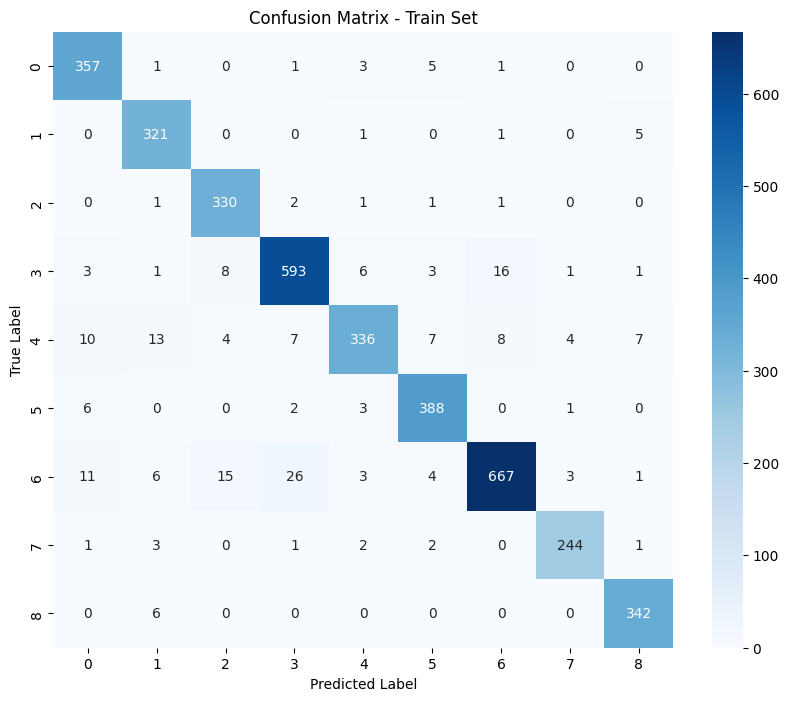

24/24 [==============================] - 1s 46ms/step

Validation Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.92      0.97      0.95        74
      2-Food Organics       0.90      0.98      0.94        66
              3-Glass       0.93      0.99      0.96        67
              4-Metal       0.93      0.96      0.95       126
5-Miscellaneous Trash       0.96      0.85      0.90        79
              6-Paper       0.97      0.95      0.96        80
            7-Plastic       0.98      0.91      0.94       147
      8-Textile Trash       0.96      0.98      0.97        51
         9-Vegetation       0.96      0.99      0.97        70

             accuracy                           0.95       760
            macro avg       0.95      0.95      0.95       760
         weighted avg       0.95      0.95      0.95       760

AUC Score: 0.9989


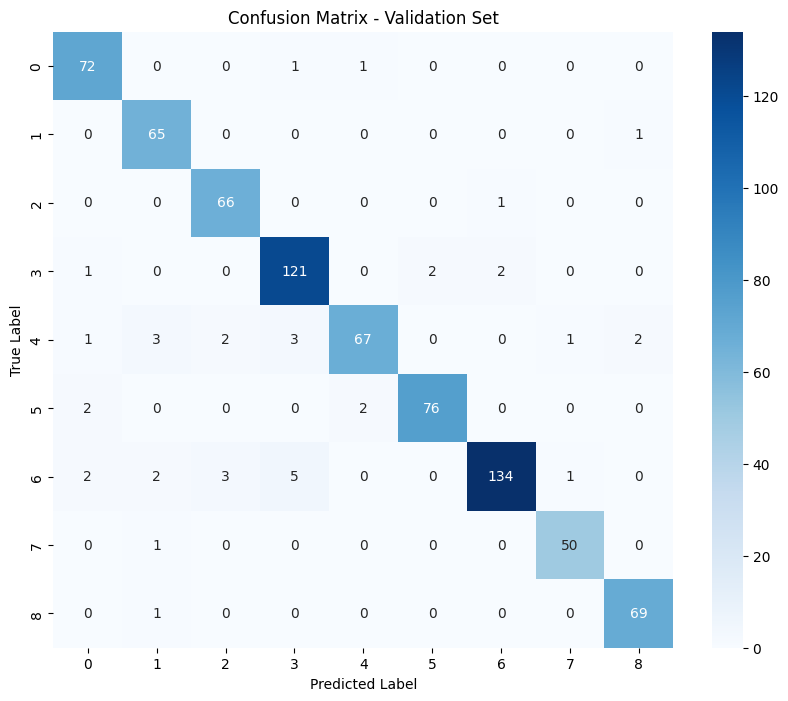

30/30 [==============================] - 2s 70ms/step

Test Set Evaluation:
--------------------------------------------------
                       precision    recall  f1-score   support

          1-Cardboard       0.77      0.82      0.79        93
      2-Food Organics       0.78      0.92      0.84        83
              3-Glass       0.82      0.69      0.75        84
              4-Metal       0.77      0.86      0.81       158
5-Miscellaneous Trash       0.69      0.54      0.60        99
              6-Paper       0.84      0.90      0.87       100
            7-Plastic       0.78      0.81      0.79       185
      8-Textile Trash       0.84      0.64      0.73        64
         9-Vegetation       0.88      0.86      0.87        88

             accuracy                           0.79       954
            macro avg       0.80      0.78      0.78       954
         weighted avg       0.79      0.79      0.79       954

AUC Score: 0.9714


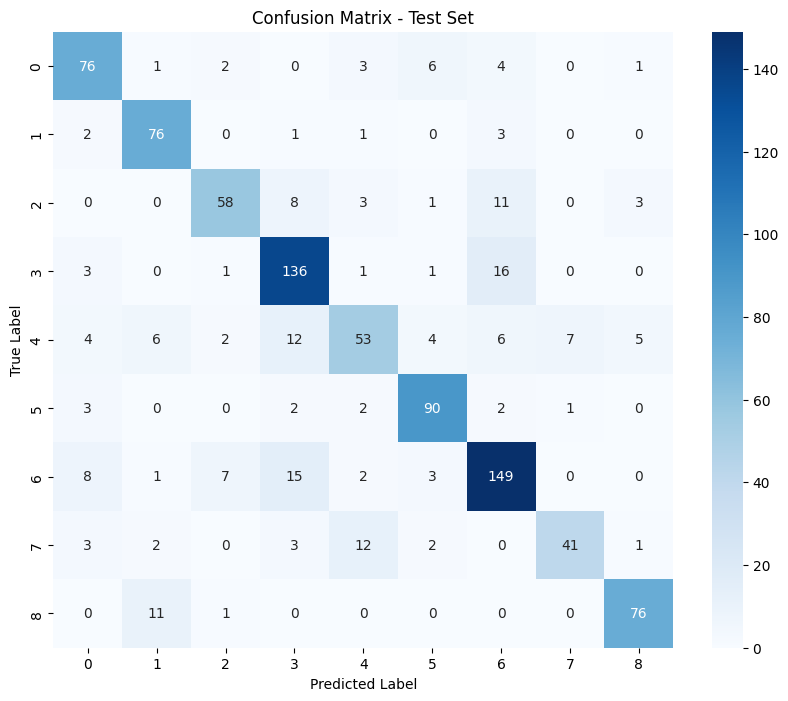

In [17]:
#reference: https://keras.io/api/applications/vgg/#vgg16-function

from tensorflow.keras.applications import VGG16

print("Training VGG16...")
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_vgg.layers:
    layer.trainable = False

model_vgg = build_model_with_head(base_model_vgg, len(class_names))
model_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Train with callbacks
history_vgg = model_vgg.fit(
    datagen.flow(X_train, y_train, batch_size=5),
    epochs=100,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train)//5,
    callbacks=get_callbacks('vgg16')
)

# Plot training history
plot_training_history(history_vgg, 'VGG16')

# Evaluate model
results_vgg = {
    'train': evaluate_model(model_vgg, X_train, y_train, class_names, "Train Set"),
    'val': evaluate_model(model_vgg, X_val, y_val, class_names, "Validation Set"),
    'test': evaluate_model(model_vgg, X_test, y_test, class_names, "Test Set")
}



### Compare models

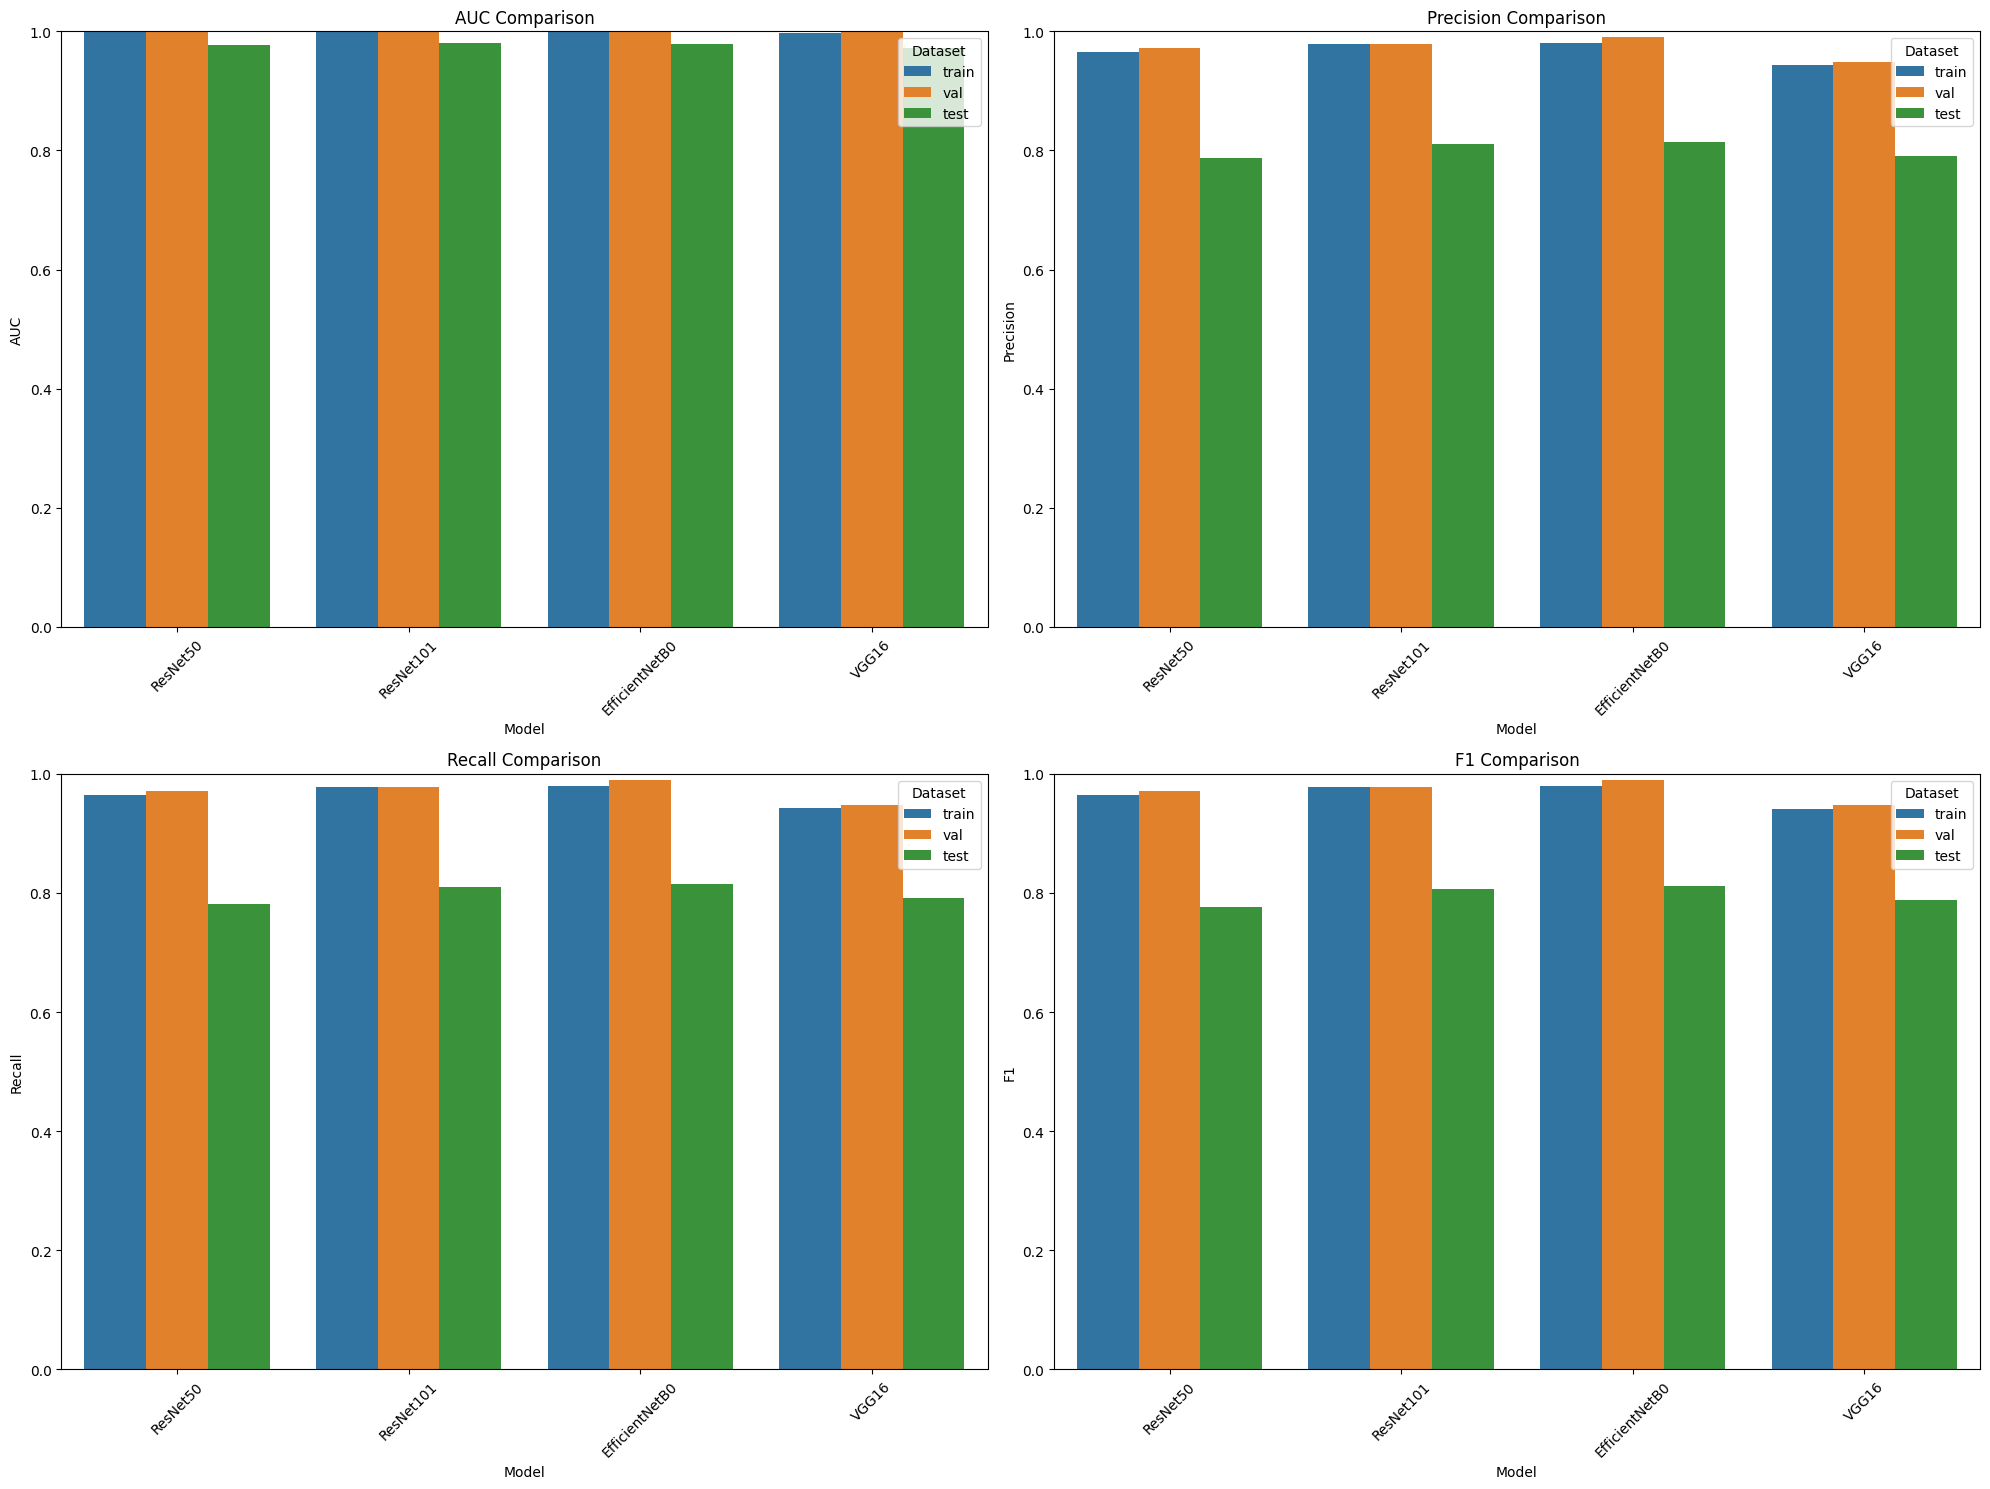

In [19]:
def compare_models(results_dict):

    data = []
    for model_name, model_results in results_dict.items():
        for dataset_name, metrics in model_results.items():
            row = {
                'Model': model_name,
                'Dataset': dataset_name,
                'AUC': metrics['auc'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1': metrics['f1']
            }
            data.append(row)
    
    # Create comparison dataframe
    df = pd.DataFrame(data)
    
    # Plot comparison
    plt.figure(figsize=(20, 15))
    metrics = ['AUC', 'Precision', 'Recall', 'F1']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        sns.barplot(data=df, x='Model', y=metric, hue='Dataset')
        plt.title(f'{metric} Comparison')
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return df

# After training all models
results = {
    'ResNet50': results_50,
    'ResNet101': results_101,
    'EfficientNetB0': results_eff,
    'VGG16': results_vgg
}

comparison_df = compare_models(results)

## Conclusion

After comprehensive evaluation of the four models (ResNet50, ResNet101, EfficientNetB0, and VGG16) on the waste classification task, EfficientNetB0 clearly outperforms other architectures, achieving the highest validation metrics with 99.07% precision, 98.29% recall, 0.999 AUC, and 98.82% F1 score. While all models demonstrated strong performance with AUC > 0.99, EfficientNetB0's superior results across all metrics, combined with its efficient architecture, make it the optimal choice for this multi-class waste classification problem, followed by ResNet50, ResNet101, and VGG16 in descending order of performance.

### References
https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
https://towardsdatascience.com/image-classification-transfer-learning-and-fine-tuning-using-tensorflow-a791baf9dbf3/
https://medium.com/analytics-vidhya/cnn-transfer-learning-with-vgg16-using-keras-b0226c0805bd